# Introduction

This notebook replicates the main figures of [Pashkovski et al. 2020](https://doi.org/10.1038/s41586-020-2451-1) "Structure and flexibility in cortical representations of odour space". 

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import sys

import h5py
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path

from sklearn.preprocessing import scale

import seaborn as sns
sns.set(style="ticks")

# load odor information

* As described in our paper, we used three odor sets that spanned odor-space at different resolutions.

In [3]:
base_path = Path().resolve().parent
data_path = base_path / "data"

sys.path.append(str(base_path / "src"))

In [4]:
GROUPS = ["global", "clustered", "tiled"]
LAYERS = ["l2", "l3"]
df_odors = pd.read_csv(data_path / "odor_sets_with_cids.csv", index_col=[0, 1])
df_odors

odor
       cid                      
global 13233      trithioacetone
       159055          R-camphor
       109332     isothiocineole
       62842            linalool
       12813   gamma-decalactone
...                          ...
tiled  264         butanoic acid
       7991       pentanoic acid
       8892        hexanoic acid
       8094       heptanoic acid
       379         octanoic acid

[66 rows x 1 columns]

In [5]:
odor_cids = {g: df_odors.loc[g].index.values for g in GROUPS}
all_cids = np.hstack([v for v in odor_cids.values()])
odor_cids

{'global': array([  13233,  159055,  109332,   62842,   12813,    8186,   17356,
        6008212,  228987,    7662,  106441,    8815,    1127,    1045,
         519793,    2346,    8405,     798,   11902,   26808,    6115,
           7976]),
 'clustered': array([6999957,    8697,   62089,   14475,    7662,  576240,    8792,
           8186,    8187, 5283356, 6436710,  159055,   14525,  444294,
          14514,   12097,   11902,   69201,  519793,    8118,   98781,
          11002]),
 'tiled': array([  527,   261,  8063,  8130,   454,   180,  6569,  7895, 11583,
         8051,  8093,  8857,  7997, 31272, 12348,  8908,  1032,   264,
         7991,  8892,  8094,   379])}

# load chemical descriptors

* For more information on the chemical descriptors, please see the supplementary table to the manuscript, or the [intuitive_descriptors.csv](../data/intuitive_descriptors.csv) file in the data folder.

In [6]:
# index data by "Name" which refers to each molecules Pubchem CID.
df_chem = pd.read_hdf(
    data_path / "chemical_descriptors.h5", key="descriptors"
).set_index("NAME")
df_chem = df_chem.iloc[:, 1:]
df_chem.head()

,MW,AMW,Sv,Se,Sp,Si,Mv,Me,Mp,Mi,...,CATS3D_10_LL,CATS3D_11_LL,CATS3D_12_LL,CATS3D_13_LL,CATS3D_14_LL,CATS3D_15_LL,CATS3D_16_LL,CATS3D_17_LL,CATS3D_18_LL,CATS3D_19_LL
NAME,,,,,,,,,,,,,,,,,,,,,
4965,229.08,10.909,14.089,21.302,15.068,23.336,0.671,1.014,0.718,1.111,...,0,0,0,0,0,0,0,0,0,0
7478,152.16,8.008,12.252,19.516,12.409,21.289,0.645,1.027,0.653,1.120,...,0,0,0,0,0,0,0,0,0,0
61431,174.32,5.127,17.224,33.374,19.284,38.986,0.507,0.982,0.567,1.147,...,0,0,0,0,0,0,0,0,0,0
6435837,284.43,6.321,26.751,44.258,29.046,50.401,0.594,0.984,0.645,1.120,...,8,2,2,0,0,0,0,0,0,0
61434,290.49,5.696,28.332,49.909,31.330,57.647,0.556,0.979,0.614,1.130,...,8,8,3,6,5,5,6,2,4,0


In [7]:
# Filter out non-volatile molecules based on molecular weight
df_chem = df_chem.loc[df_chem.MW < 300]
df_chem = df_chem.loc[df_chem.MW > 50]

# remove descriptors that have a zero value across all the odors we've tested
colFilter = ~(df_chem.loc[all_cids].astype(bool).sum(0) == 0)
df_chem = df_chem.loc[:, colFilter]

# z-score each descriptor feature across the full odor library
chem_scaled = scale(df_chem.values, axis=0)

In [8]:
odor_idx = {}
for k, v in odor_cids.items():
    odor_idx[k] = [np.where(df_chem.index == vv)[0][0] for vv in v]

# load neural pseudopopulations

* responses are concatenated across mice

In [9]:
with h5py.File(data_path / "pseudopopulations.h5", "r") as hf:
    neural_dict = {k: v[()] for k, v in hf["pseudopopulations"].items()}
    
# trials x ROIs x odors
for k, v in neural_dict.items():
    print(k, v.shape)

Boutons (6, 3160, 22)
Model (1, 72914, 22)
TeLC L2 (4, 435, 22)
TeLC L3 (4, 590, 22)
clustered_l2 (10, 867, 22)
clustered_l3 (10, 488, 22)
global_l2 (10, 854, 22)
global_l3 (10, 616, 22)
tiled_l2 (7, 427, 22)
tiled_l3 (7, 334, 22)


# make plots for correlation distance matrices

* for the neural data, we averaged across trials and then took the correlation distance across odors

In [10]:
from viz import plot_corrs, scatter_dist
from dist import chem_dist_mat, neural_dist_mat

In [11]:
default_keys = [
    "global_l2",
    "global_l3",
    "clustered_l2",
    "clustered_l3",
    "tiled_l2",
    "tiled_l3",
]
neural_subset = {k: neural_dict[k] for k in default_keys}

neural_corrs = {k: neural_dist_mat(pseudopop=v) for k, v in neural_subset.items()}
chem_corrs = {k: chem_dist_mat(chem_scaled[v]) for k, v in odor_idx.items()}

for k, v in chem_corrs.items():
    print(k, v.shape)

global (22, 22)
clustered (22, 22)
tiled (22, 22)


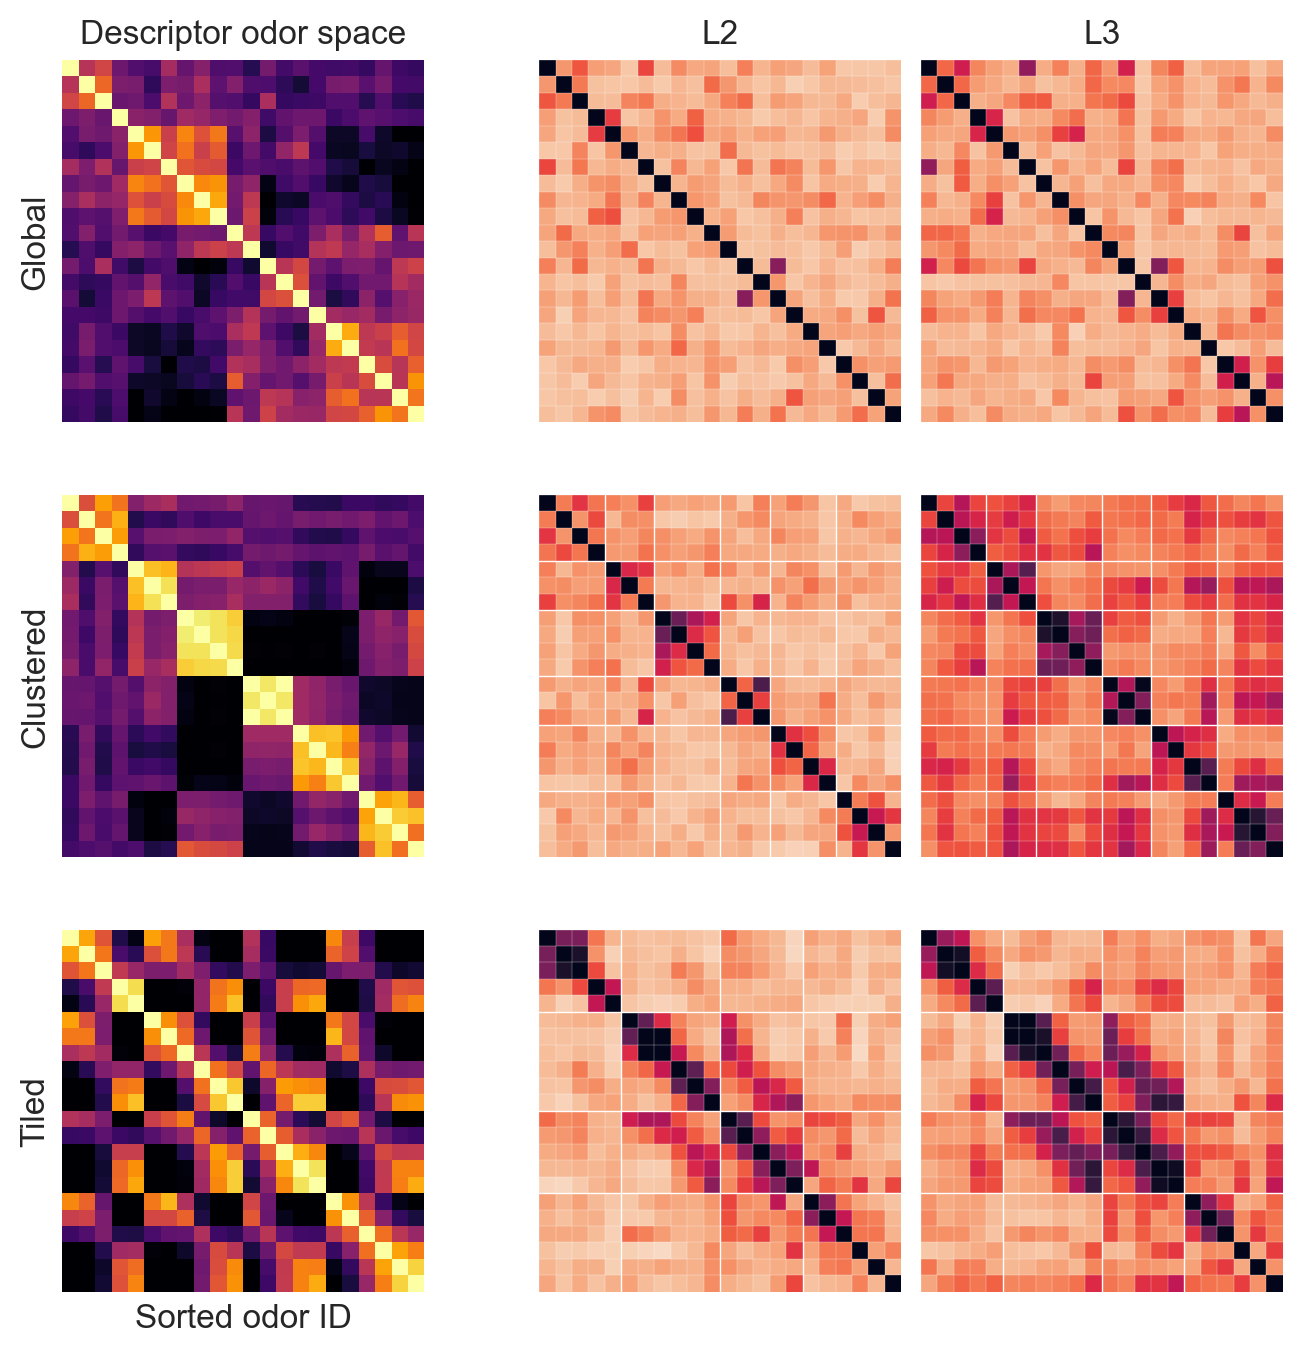

In [12]:
fig = plot_corrs(chem_corrs, neural_corrs)

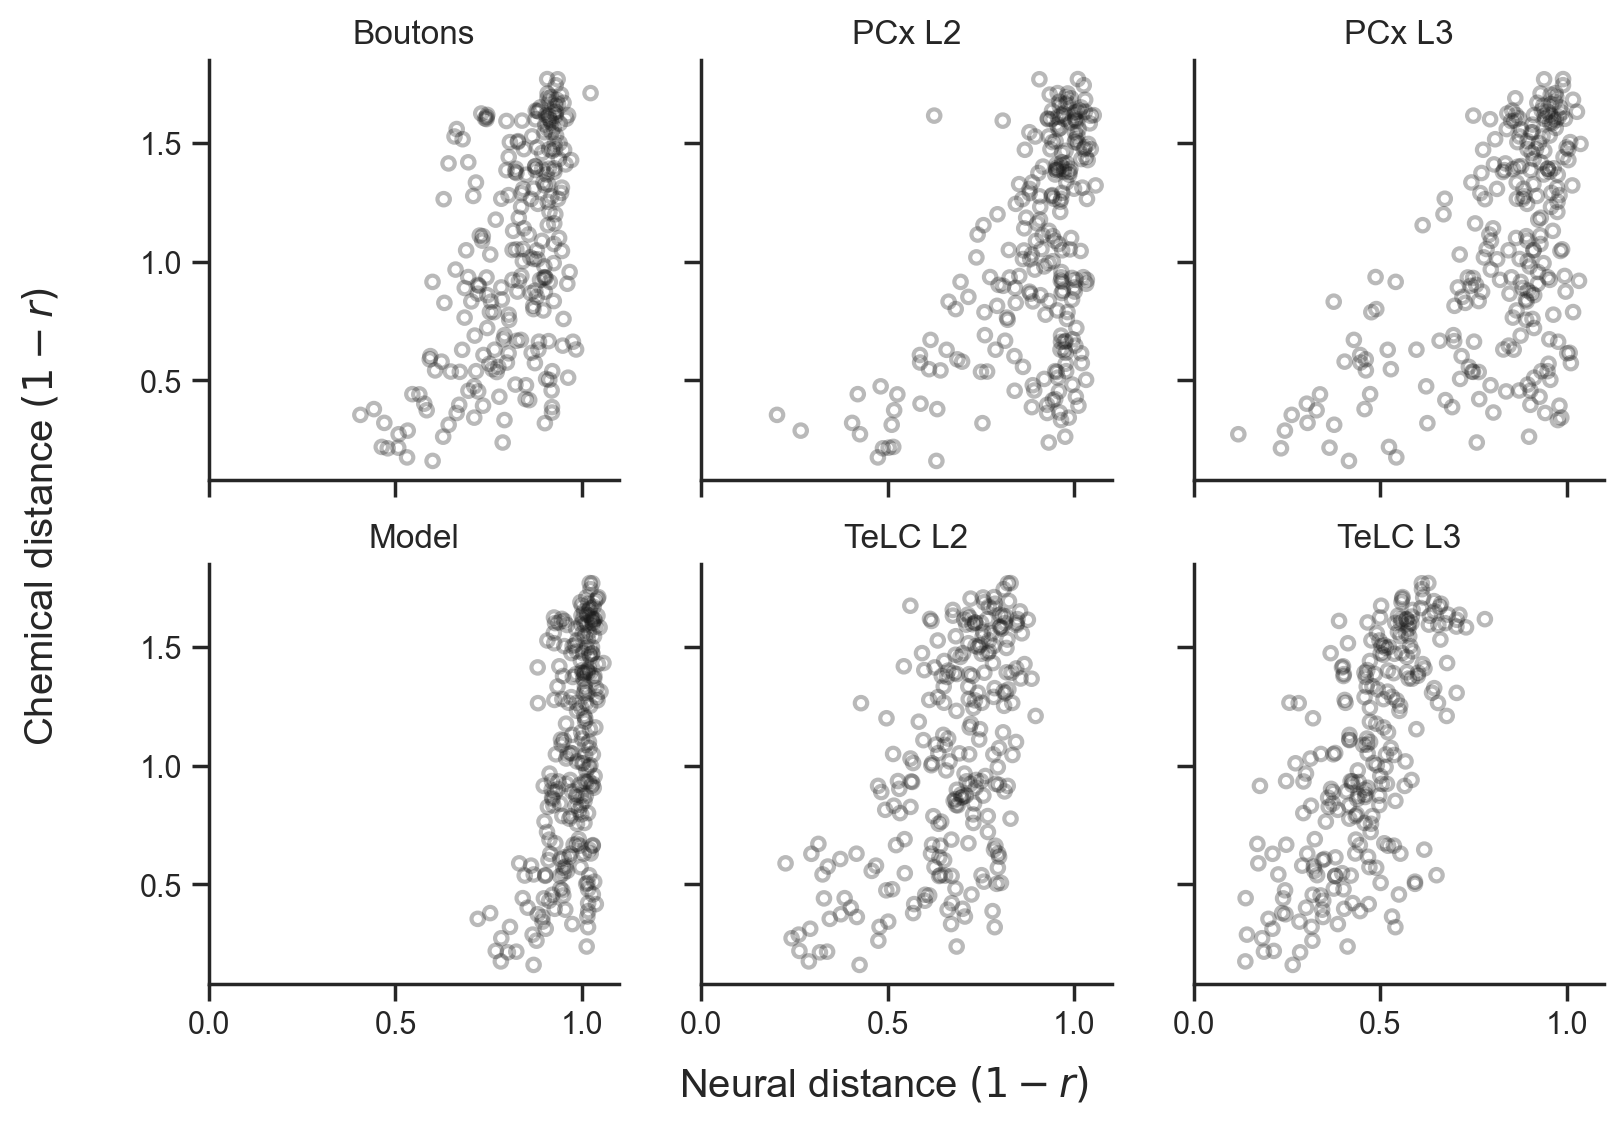

In [13]:
fig2 = scatter_dist(chem_scaled[odor_idx["tiled"]], neural_dict)